# 12-Class Fetal Ultrasound Classification

This notebook trains a 12-class classifier for fetal ultrasound images with:
- Stratified splits to ensure all classes in train/val/test
- Focal loss to handle 5:1 class imbalance
- Comprehensive metrics (balanced accuracy, macro F1, Cohen's Kappa)
- MLflow experiment tracking

## 1. Setup and Imports

In [1]:
import sys
import os
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import mlflow
import mlflow.pytorch
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    cohen_kappa_score, classification_report, confusion_matrix
)

from src.data.dataset import FetalDataModule12Class
from src.data.augmentation import get_training_augmentation, get_validation_augmentation
from src.models.classifier import create_model
from src.utils.training import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Configuration

In [2]:
class Config:
    # Data
    data_root = 'data/Fetal Ultrasound'
    image_size = 224
    num_classes = 12
    subset_fraction = 0.1  # Use 10% of dataset for faster training
    
    # Model
    backbone = 'efficientnet_b0'  # Options: efficientnet_b0, resnet18, densenet121, mobilenet_v2
    pretrained = True
    dropout = 0.2
    
    # Training
    batch_size = 32
    epochs = 30  # Full training
    learning_rate = 1e-3
    weight_decay = 1e-4
    
    # Loss
    use_focal_loss = True
    focal_gamma = 2.0
    
    # Early stopping
    patience = 7
    
    # System
    num_workers = 0  # Set to 0 for Windows
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    seed = 42
    
    # MLflow
    use_mlflow = True
    experiment_name = '12-class-ultrasound'

config = Config()
print(f"Using device: {config.device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Dataset fraction: {config.subset_fraction*100:.0f}%")

Using device: cuda
CUDA available: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Dataset fraction: 10%


## 3. Set Random Seeds

In [3]:
def set_seed(seed):
    """Set random seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config.seed)
print("Random seeds set for reproducibility")

Random seeds set for reproducibility


## 4. Load and Prepare Data

In [4]:
# Initialize data module
print("Initializing data module...")
data_module = FetalDataModule12Class(
    data_root=config.data_root,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
    random_state=config.seed,
    subset_fraction=config.subset_fraction
)

# Setup with augmentations
data_module.setup(
    train_transform=get_training_augmentation(config.image_size),
    val_transform=get_validation_augmentation(config.image_size)
)

# Get dataloaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

print(f"\nDataset sizes:")
print(f"  Train: {len(data_module.train_dataset)} samples")
print(f"  Val: {len(data_module.val_dataset)} samples")
print(f"  Test: {len(data_module.test_dataset)} samples")

Initializing data module...



Dataset sizes:
  Train: 1049 samples
  Val: 226 samples
  Test: 225 samples


## 5. Visualize Class Distribution

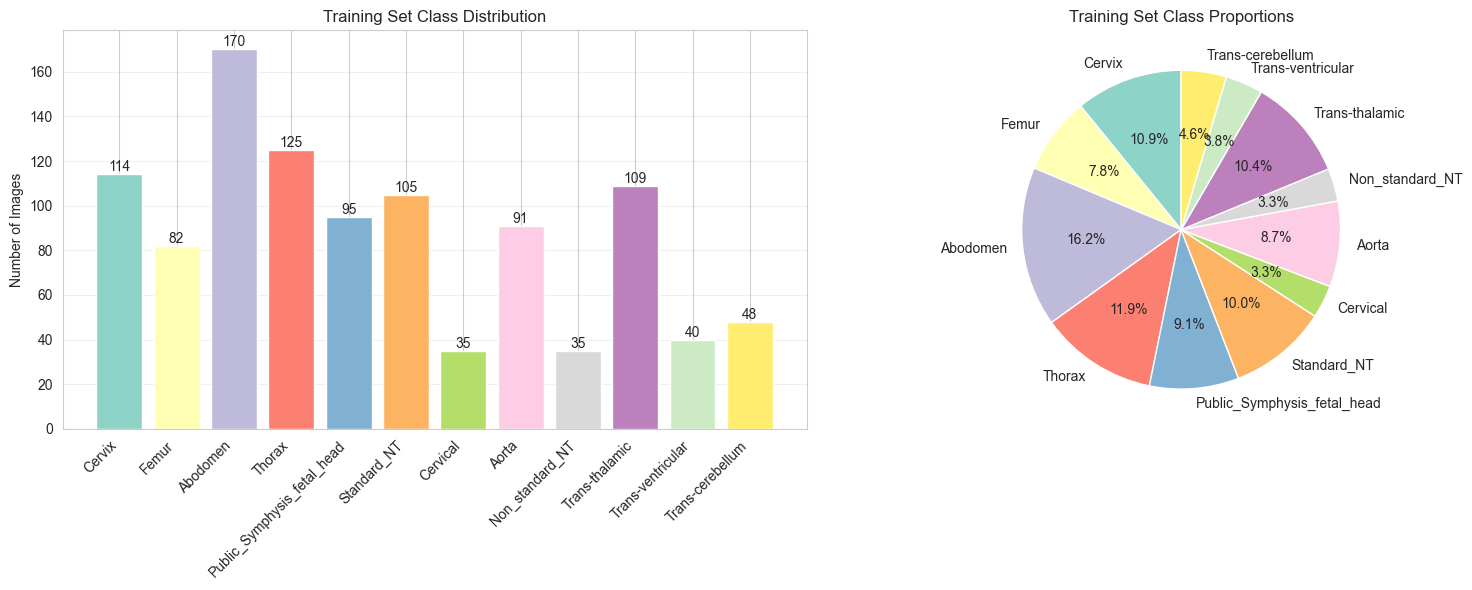


Class Weights (for balancing):
  Abodomen                      : 0.514
  Aorta                         : 0.961
  Cervical                      : 2.498
  Cervix                        : 0.767
  Femur                         : 1.066
  Non_standard_NT               : 2.498
  Public_Symphysis_fetal_head   : 0.920
  Standard_NT                   : 0.833
  Thorax                        : 0.699
  Trans-cerebellum              : 1.821
  Trans-thalamic                : 0.802
  Trans-ventricular             : 2.185


In [5]:
# Get class distribution
train_dist = data_module.train_dataset.get_class_distribution()
class_names = data_module.train_dataset.CLASSES

# Plot distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
classes = list(train_dist.keys())
counts = list(train_dist.values())
colors = plt.cm.Set3(np.linspace(0, 1, len(classes)))

bars = ax1.bar(range(len(classes)), counts, color=colors)
ax1.set_xticks(range(len(classes)))
ax1.set_xticklabels(classes, rotation=45, ha='right')
ax1.set_ylabel('Number of Images')
ax1.set_title('Training Set Class Distribution')
ax1.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}', ha='center', va='bottom')

# Pie chart
ax2.pie(counts, labels=classes, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Training Set Class Proportions')

plt.tight_layout()
plt.show()

# Print class weights
print("\nClass Weights (for balancing):")
for i, class_name in enumerate(class_names):
    weight = data_module.class_weights[i].item()
    print(f"  {class_name:30s}: {weight:.3f}")

## 6. Create Model and Loss Function

In [6]:
# Create model with focal loss and class weights
print(f"Creating model: {config.backbone}")
model, criterion = create_model(
    num_classes=config.num_classes,
    backbone=config.backbone,
    pretrained=config.pretrained,
    dropout_rate=config.dropout,
    class_weights=data_module.class_weights.to(config.device),
    use_focal_loss=config.use_focal_loss,
    focal_gamma=config.focal_gamma
)

model = model.to(config.device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

Creating model: efficientnet_b0



Model Parameters:
  Total: 4,022,920
  Trainable: 4,022,920


## 7. Setup Optimizer and Scheduler

In [7]:
# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.epochs,
    eta_min=1e-6
)

# Mixed precision scaler for faster training
scaler = GradScaler()

print(f"Optimizer: AdamW (lr={config.learning_rate}, wd={config.weight_decay})")
print(f"Scheduler: CosineAnnealingLR")
print(f"Mixed Precision: Enabled")

Optimizer: AdamW (lr=0.001, wd=0.0001)
Scheduler: CosineAnnealingLR
Mixed Precision: Enabled


## 8. Initialize Tracking

In [8]:
# Early stopping
early_stopping = EarlyStopping(
    patience=config.patience,
    mode='max',
    verbose=True
)

# Model checkpoint
Path('models').mkdir(exist_ok=True)
checkpoint = ModelCheckpoint(
    filepath=f'models/best_model_{config.backbone}_12class.pth',
    monitor='balanced_accuracy',
    mode='max',
    verbose=True
)

# MLflow
if config.use_mlflow:
    mlflow.set_experiment(config.experiment_name)
    mlflow.start_run()
    
    # Log configuration
    mlflow.log_params({
        'backbone': config.backbone,
        'pretrained': config.pretrained,
        'batch_size': config.batch_size,
        'learning_rate': config.learning_rate,
        'epochs': config.epochs,
        'image_size': config.image_size,
        'use_focal_loss': config.use_focal_loss,
        'focal_gamma': config.focal_gamma,
        'dropout': config.dropout,
        'weight_decay': config.weight_decay,
        'num_classes': config.num_classes
    })
    print("MLflow tracking started")

print("Tracking initialized")

MLflow tracking started
Tracking initialized


## 9. Training Functions

In [9]:
def train_epoch(model, dataloader, criterion, optimizer, scaler, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(dataloader, desc='Training', leave=False)
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision training
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Statistics
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc, epoch_balanced_acc


def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    
    # Calculate comprehensive metrics
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'balanced_accuracy': balanced_accuracy_score(all_labels, all_preds),
        'macro_f1': f1_score(all_labels, all_preds, average='macro'),
        'weighted_f1': f1_score(all_labels, all_preds, average='weighted'),
        'cohen_kappa': cohen_kappa_score(all_labels, all_preds)
    }
    
    return epoch_loss, metrics, all_preds, all_labels

## 10. Training Loop

In [10]:
# Training history
history = {
    'train_loss': [], 'train_acc': [], 'train_balanced_acc': [],
    'val_loss': [], 'val_acc': [], 'val_balanced_acc': [],
    'val_macro_f1': [], 'val_cohen_kappa': []
}

best_balanced_acc = 0.0

print("Starting training...\n")
print("="*80)

for epoch in range(config.epochs):
    print(f"\nEpoch {epoch+1}/{config.epochs}")
    print("-"*40)
    
    # Train
    train_loss, train_acc, train_balanced_acc = train_epoch(
        model, train_loader, criterion, optimizer, scaler, config.device
    )
    
    # Validate
    val_loss, val_metrics, val_preds, val_labels = validate(
        model, val_loader, criterion, config.device
    )
    
    # Update scheduler
    scheduler.step()
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_balanced_acc'].append(train_balanced_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_balanced_acc'].append(val_metrics['balanced_accuracy'])
    history['val_macro_f1'].append(val_metrics['macro_f1'])
    history['val_cohen_kappa'].append(val_metrics['cohen_kappa'])
    
    # Print metrics
    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Balanced Acc: {train_balanced_acc:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_metrics['accuracy']:.4f}, Balanced Acc: {val_metrics['balanced_accuracy']:.4f}")
    print(f"        Macro F1: {val_metrics['macro_f1']:.4f}, Cohen's Kappa: {val_metrics['cohen_kappa']:.4f}")
    
    # MLflow logging
    if config.use_mlflow:
        mlflow.log_metrics({
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'train_balanced_accuracy': train_balanced_acc,
            'val_loss': val_loss,
            **{f'val_{k}': v for k, v in val_metrics.items()},
            'learning_rate': optimizer.param_groups[0]['lr']
        }, step=epoch)
    
    # Checkpoint and early stopping
    checkpoint(val_metrics['balanced_accuracy'], model, optimizer, epoch)
    
    if early_stopping(val_metrics['balanced_accuracy']):
        print("\nEarly stopping triggered!")
        break
    
    # Update best score
    if val_metrics['balanced_accuracy'] > best_balanced_acc:
        best_balanced_acc = val_metrics['balanced_accuracy']

print("\n" + "="*80)
print(f"Training complete! Best validation balanced accuracy: {best_balanced_acc:.4f}")

Starting training...


Epoch 1/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 1.3584, Acc: 0.4185, Balanced Acc: 0.4113
Val   - Loss: 0.4001, Acc: 0.7876, Balanced Acc: 0.7083
        Macro F1: 0.6745, Cohen's Kappa: 0.7629

Epoch 2/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.6239, Acc: 0.6044, Balanced Acc: 0.5945
Val   - Loss: 0.2837, Acc: 0.7478, Balanced Acc: 0.7342
        Macro F1: 0.6836, Cohen's Kappa: 0.7219

Epoch 3/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.4750, Acc: 0.6806, Balanced Acc: 0.6634
Val   - Loss: 0.1380, Acc: 0.8407, Balanced Acc: 0.8308
        Macro F1: 0.8040, Cohen's Kappa: 0.8238

Epoch 4/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.3629, Acc: 0.7512, Balanced Acc: 0.7322
Val   - Loss: 0.2253, Acc: 0.7965, Balanced Acc: 0.7942
        Macro F1: 0.7422, Cohen's Kappa: 0.7753

Epoch 5/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.3073, Acc: 0.7531, Balanced Acc: 0.7295
Val   - Loss: 0.1363, Acc: 0.8097, Balanced Acc: 0.7965
        Macro F1: 0.7632, Cohen's Kappa: 0.7903

Epoch 6/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.2597, Acc: 0.8027, Balanced Acc: 0.7905
Val   - Loss: 0.1506, Acc: 0.8451, Balanced Acc: 0.8428
        Macro F1: 0.8179, Cohen's Kappa: 0.8285

Epoch 7/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.2749, Acc: 0.7941, Balanced Acc: 0.7656
Val   - Loss: 0.1595, Acc: 0.8053, Balanced Acc: 0.7878
        Macro F1: 0.7335, Cohen's Kappa: 0.7852

Epoch 8/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.2422, Acc: 0.8046, Balanced Acc: 0.7841
Val   - Loss: 0.0911, Acc: 0.8850, Balanced Acc: 0.8698
        Macro F1: 0.8503, Cohen's Kappa: 0.8724

Epoch 9/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.2245, Acc: 0.8227, Balanced Acc: 0.8148
Val   - Loss: 0.1267, Acc: 0.8717, Balanced Acc: 0.8119
        Macro F1: 0.8007, Cohen's Kappa: 0.8571

Epoch 10/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.1889, Acc: 0.8437, Balanced Acc: 0.8168
Val   - Loss: 0.1258, Acc: 0.8407, Balanced Acc: 0.8300
        Macro F1: 0.8071, Cohen's Kappa: 0.8240

Epoch 11/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.1619, Acc: 0.8475, Balanced Acc: 0.8367
Val   - Loss: 0.1105, Acc: 0.8805, Balanced Acc: 0.8582
        Macro F1: 0.8458, Cohen's Kappa: 0.8673

Epoch 12/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.1524, Acc: 0.8627, Balanced Acc: 0.8516
Val   - Loss: 0.1046, Acc: 0.8673, Balanced Acc: 0.8593
        Macro F1: 0.8316, Cohen's Kappa: 0.8531

Epoch 13/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.1446, Acc: 0.8723, Balanced Acc: 0.8666
Val   - Loss: 0.0914, Acc: 0.8938, Balanced Acc: 0.8777
        Macro F1: 0.8628, Cohen's Kappa: 0.8821

Epoch 14/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.1410, Acc: 0.8818, Balanced Acc: 0.8759
Val   - Loss: 0.0835, Acc: 0.9027, Balanced Acc: 0.8903
        Macro F1: 0.8709, Cohen's Kappa: 0.8921

Epoch 15/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.1336, Acc: 0.8751, Balanced Acc: 0.8550
Val   - Loss: 0.0906, Acc: 0.8894, Balanced Acc: 0.8729
        Macro F1: 0.8549, Cohen's Kappa: 0.8775

Epoch 16/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.1215, Acc: 0.8942, Balanced Acc: 0.8898
Val   - Loss: 0.0856, Acc: 0.8982, Balanced Acc: 0.8625
        Macro F1: 0.8586, Cohen's Kappa: 0.8869

Epoch 17/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.1077, Acc: 0.8923, Balanced Acc: 0.8857
Val   - Loss: 0.0774, Acc: 0.8938, Balanced Acc: 0.8681
        Macro F1: 0.8601, Cohen's Kappa: 0.8820

Epoch 18/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.0952, Acc: 0.9037, Balanced Acc: 0.8987
Val   - Loss: 0.0848, Acc: 0.9071, Balanced Acc: 0.8754
        Macro F1: 0.8719, Cohen's Kappa: 0.8966

Epoch 19/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.0919, Acc: 0.9047, Balanced Acc: 0.8990
Val   - Loss: 0.0657, Acc: 0.9115, Balanced Acc: 0.9011
        Macro F1: 0.8869, Cohen's Kappa: 0.9017



Epoch 20/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.0760, Acc: 0.9133, Balanced Acc: 0.9093
Val   - Loss: 0.0650, Acc: 0.8982, Balanced Acc: 0.8709
        Macro F1: 0.8661, Cohen's Kappa: 0.8869

Epoch 21/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.0795, Acc: 0.9295, Balanced Acc: 0.9211
Val   - Loss: 0.0673, Acc: 0.9071, Balanced Acc: 0.8868
        Macro F1: 0.8760, Cohen's Kappa: 0.8968

Epoch 22/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.0887, Acc: 0.9199, Balanced Acc: 0.9165
Val   - Loss: 0.0804, Acc: 0.9027, Balanced Acc: 0.8802
        Macro F1: 0.8698, Cohen's Kappa: 0.8918

Epoch 23/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.0650, Acc: 0.9361, Balanced Acc: 0.9363
Val   - Loss: 0.0728, Acc: 0.9027, Balanced Acc: 0.8951
        Macro F1: 0.8762, Cohen's Kappa: 0.8920

Epoch 24/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.0622, Acc: 0.9409, Balanced Acc: 0.9333
Val   - Loss: 0.0632, Acc: 0.9115, Balanced Acc: 0.8924
        Macro F1: 0.8815, Cohen's Kappa: 0.9017

Epoch 25/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.0504, Acc: 0.9542, Balanced Acc: 0.9497
Val   - Loss: 0.0627, Acc: 0.9027, Balanced Acc: 0.8810
        Macro F1: 0.8717, Cohen's Kappa: 0.8919

Epoch 26/30
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.0668, Acc: 0.9285, Balanced Acc: 0.9197
Val   - Loss: 0.0662, Acc: 0.9115, Balanced Acc: 0.8915
        Macro F1: 0.8804, Cohen's Kappa: 0.9017

Early stopping triggered!

Training complete! Best validation balanced accuracy: 0.9011


## 11. Plot Training History

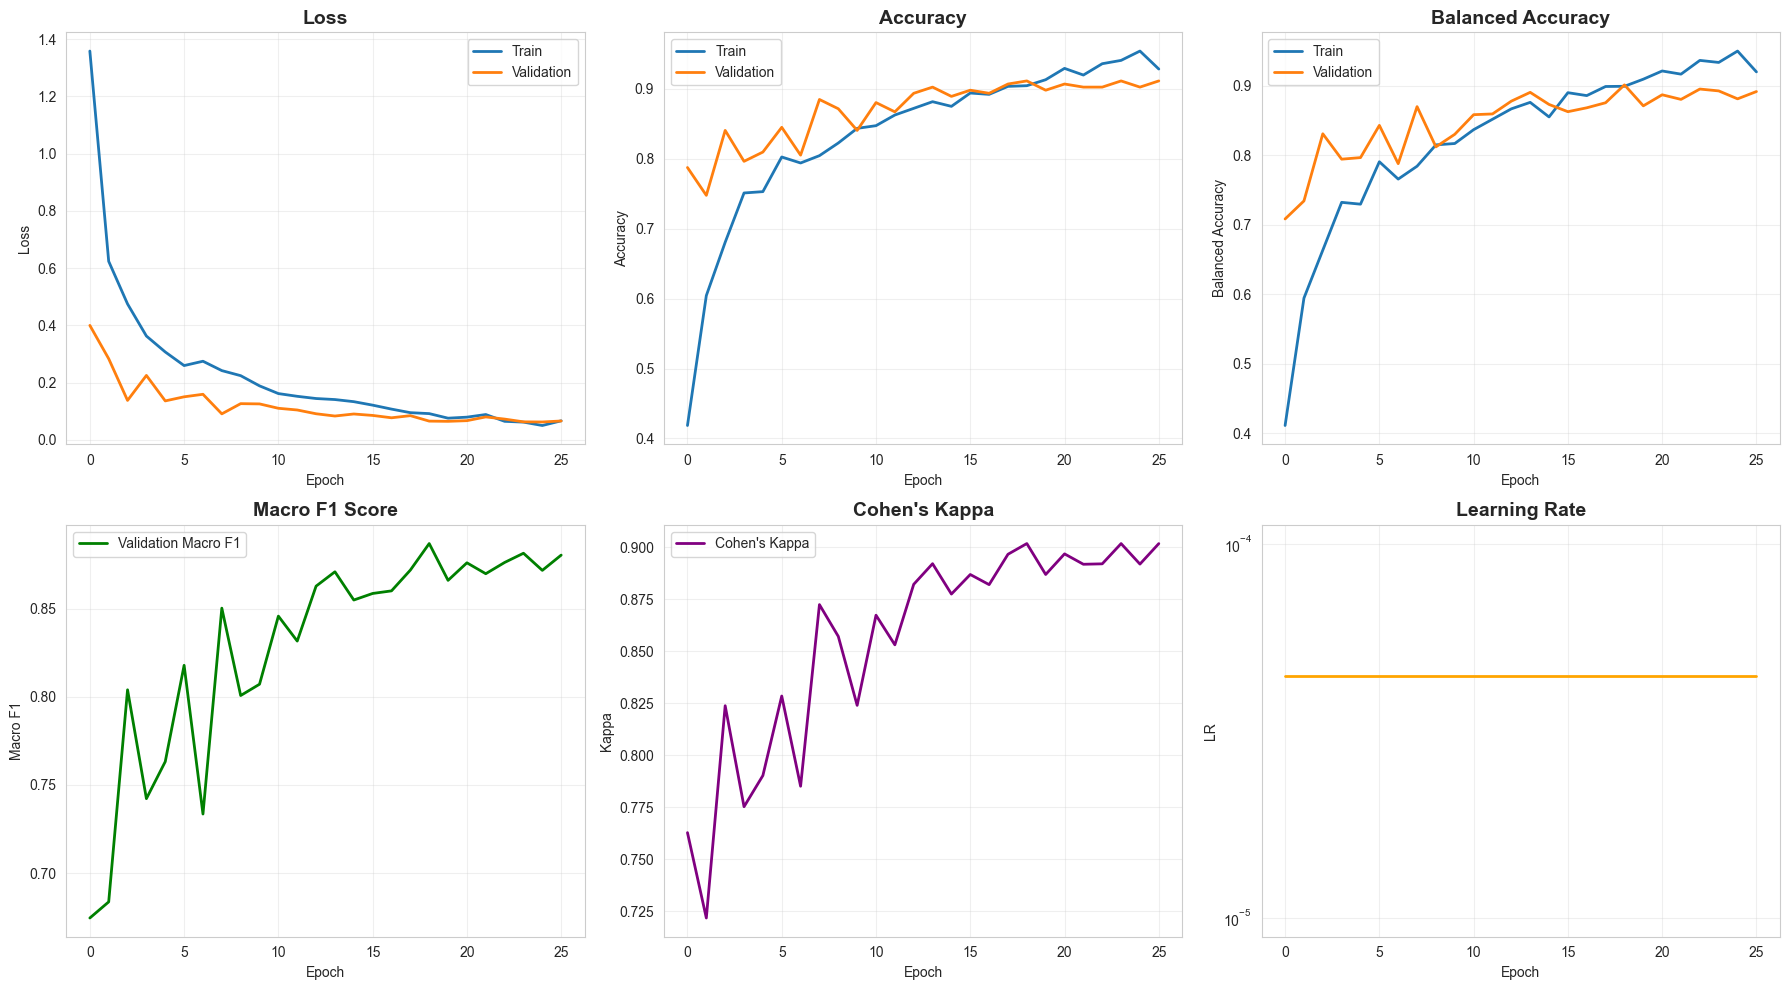

In [11]:
# Plot training history
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Validation', linewidth=2)
axes[0, 1].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Balanced Accuracy
axes[0, 2].plot(history['train_balanced_acc'], label='Train', linewidth=2)
axes[0, 2].plot(history['val_balanced_acc'], label='Validation', linewidth=2)
axes[0, 2].set_title('Balanced Accuracy', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Balanced Accuracy')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Macro F1
axes[1, 0].plot(history['val_macro_f1'], label='Validation Macro F1', linewidth=2, color='green')
axes[1, 0].set_title('Macro F1 Score', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Macro F1')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Cohen's Kappa
axes[1, 1].plot(history['val_cohen_kappa'], label="Cohen's Kappa", linewidth=2, color='purple')
axes[1, 1].set_title("Cohen's Kappa", fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Kappa')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Learning Rate
lrs = [optimizer.param_groups[0]['lr']] * len(history['train_loss'])
axes[1, 2].plot(lrs, linewidth=2, color='orange')
axes[1, 2].set_title('Learning Rate', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('LR')
axes[1, 2].set_yscale('log')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Load Best Model and Test

In [12]:
# Load best model
checkpoint_path = f'models/best_model_{config.backbone}_12class.pth'
if Path(checkpoint_path).exists():
    checkpoint_dict = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint_dict['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint_dict['epoch']+1}")
else:
    print("No checkpoint found, using current model")

# Test evaluation
print("\nEvaluating on test set...")
test_loss, test_metrics, test_preds, test_labels = validate(
    model, test_loader, criterion, config.device
)

print("\n" + "="*80)
print("TEST SET RESULTS")
print("="*80)
print(f"Test Loss: {test_loss:.4f}")
print(f"\nTest Metrics:")
for metric_name, value in test_metrics.items():
    print(f"  {metric_name:20s}: {value:.4f}")

Loaded best model from epoch 19

Evaluating on test set...


Validation:   0%|          | 0/8 [00:00<?, ?it/s]


TEST SET RESULTS
Test Loss: 0.2354

Test Metrics:
  accuracy            : 0.8800
  balanced_accuracy   : 0.8575
  macro_f1            : 0.8499
  weighted_f1         : 0.8830
  cohen_kappa         : 0.8669


## 13. Classification Report

In [13]:
# Detailed classification report
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)

class_names = data_module.train_dataset.CLASSES
report = classification_report(test_labels, test_preds, target_names=class_names, digits=3)
print(report)

# Save report
report_dict = classification_report(
    test_labels, test_preds,
    target_names=class_names,
    output_dict=True
)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(3)


CLASSIFICATION REPORT
                             precision    recall  f1-score   support

                   Abodomen      0.921     0.972     0.946        36
                      Aorta      1.000     1.000     1.000        20
                   Cervical      1.000     1.000     1.000         8
                     Cervix      1.000     1.000     1.000        24
                      Femur      0.947     1.000     0.973        18
            Non_standard_NT      0.278     0.714     0.400         7
Public_Symphysis_fetal_head      1.000     1.000     1.000        20
                Standard_NT      0.833     0.435     0.571        23
                     Thorax      0.960     0.889     0.923        27
           Trans-cerebellum      0.875     0.700     0.778        10
             Trans-thalamic      0.808     0.913     0.857        23
          Trans-ventricular      0.857     0.667     0.750         9

                   accuracy                          0.880       225
         

## 14. Confusion Matrix

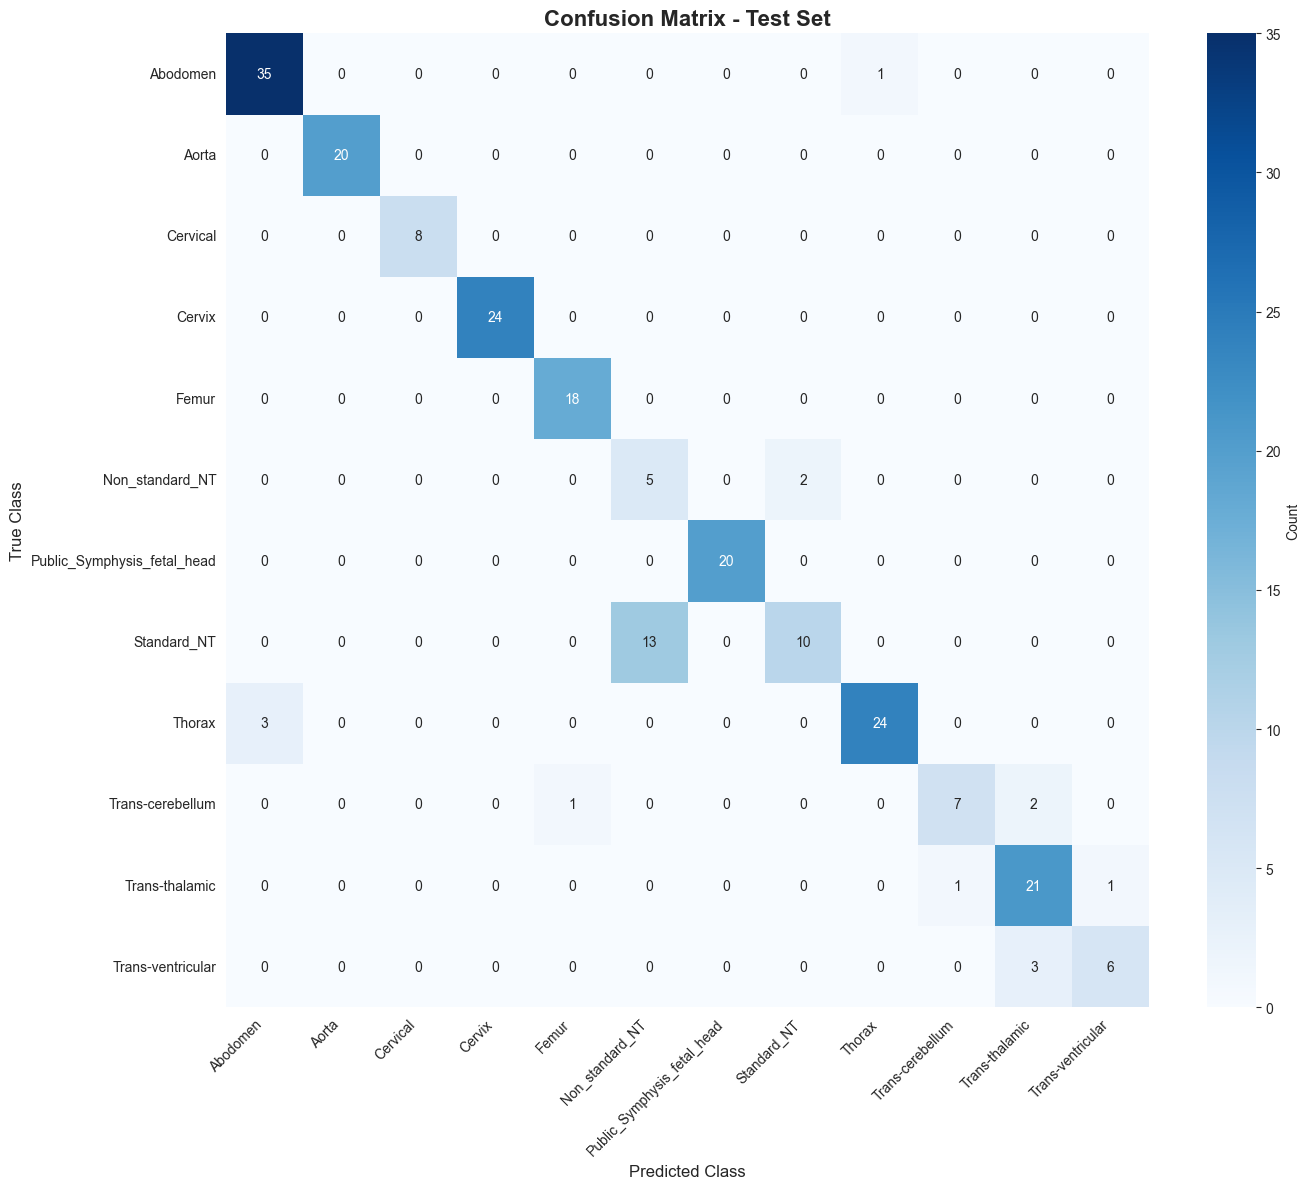

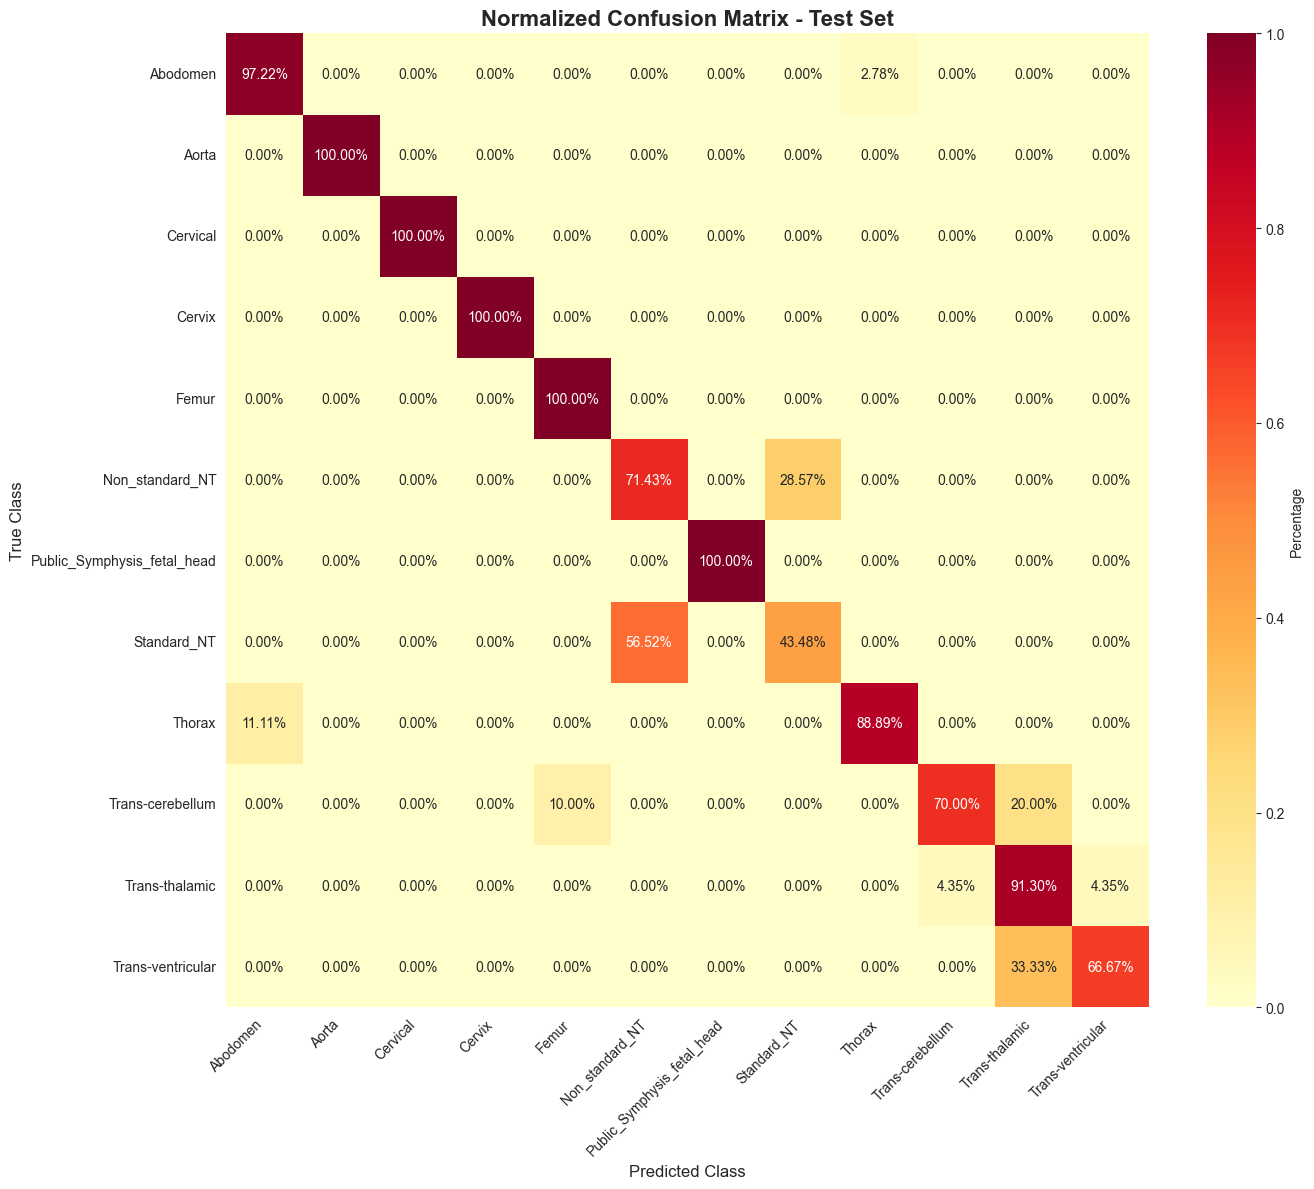

In [14]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlOrRd',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 15. Per-Class Performance Analysis

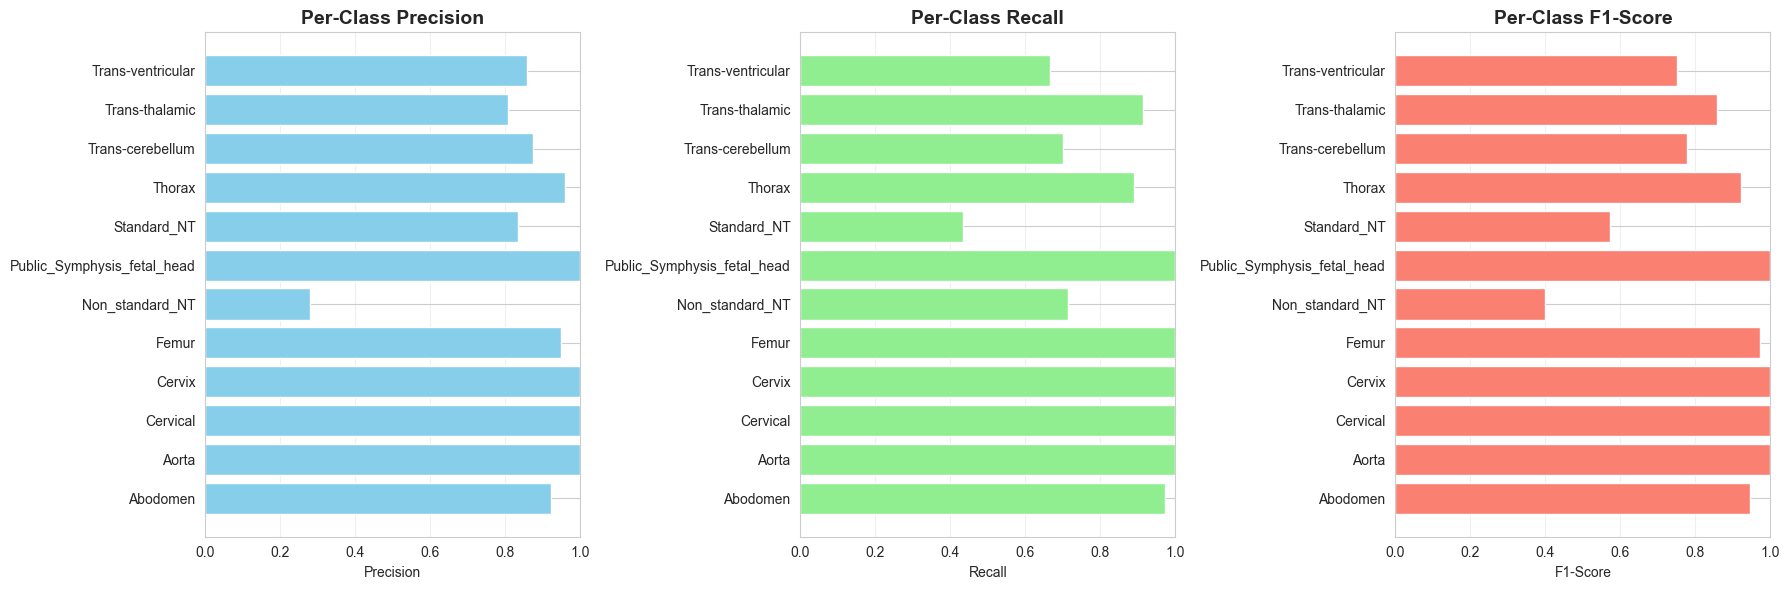


Per-Class Performance:
                      Class  Precision   Recall  F1-Score  Support
                   Abodomen   0.921053 0.972222  0.945946       36
                      Aorta   1.000000 1.000000  1.000000       20
                   Cervical   1.000000 1.000000  1.000000        8
                     Cervix   1.000000 1.000000  1.000000       24
                      Femur   0.947368 1.000000  0.972973       18
            Non_standard_NT   0.277778 0.714286  0.400000        7
Public_Symphysis_fetal_head   1.000000 1.000000  1.000000       20
                Standard_NT   0.833333 0.434783  0.571429       23
                     Thorax   0.960000 0.888889  0.923077       27
           Trans-cerebellum   0.875000 0.700000  0.777778       10
             Trans-thalamic   0.807692 0.913043  0.857143       23
          Trans-ventricular   0.857143 0.666667  0.750000        9


In [15]:
# Extract per-class metrics
per_class_metrics = []
for i, class_name in enumerate(class_names):
    if class_name in report_dict:
        metrics = report_dict[class_name]
        per_class_metrics.append({
            'Class': class_name,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1-score'],
            'Support': int(metrics['support'])
        })

metrics_df = pd.DataFrame(per_class_metrics)

# Plot per-class performance
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision
axes[0].barh(metrics_df['Class'], metrics_df['Precision'], color='skyblue')
axes[0].set_xlabel('Precision')
axes[0].set_title('Per-Class Precision', fontsize=14, fontweight='bold')
axes[0].set_xlim([0, 1])
axes[0].grid(axis='x', alpha=0.3)

# Recall
axes[1].barh(metrics_df['Class'], metrics_df['Recall'], color='lightgreen')
axes[1].set_xlabel('Recall')
axes[1].set_title('Per-Class Recall', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1])
axes[1].grid(axis='x', alpha=0.3)

# F1-Score
axes[2].barh(metrics_df['Class'], metrics_df['F1-Score'], color='salmon')
axes[2].set_xlabel('F1-Score')
axes[2].set_title('Per-Class F1-Score', fontsize=14, fontweight='bold')
axes[2].set_xlim([0, 1])
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Display metrics table
print("\nPer-Class Performance:")
print(metrics_df.to_string(index=False))

## 16. Error Analysis

In [16]:
# Find most confused class pairs
confusion_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'True': class_names[i],
                'Predicted': class_names[j],
                'Count': cm[i, j],
                'Percentage': cm_normalized[i, j] * 100
            })

confusion_df = pd.DataFrame(confusion_pairs)
confusion_df = confusion_df.sort_values('Count', ascending=False)

print("\n" + "="*80)
print("TOP CONFUSION PAIRS")
print("="*80)
print("\nMost confused class pairs (top 10):")
print(confusion_df.head(10).to_string(index=False))

# Classes with lowest performance
print("\n" + "="*80)
print("CLASSES NEEDING IMPROVEMENT")
print("="*80)
worst_classes = metrics_df.nsmallest(5, 'F1-Score')
print("\nClasses with lowest F1-scores:")
print(worst_classes.to_string(index=False))


TOP CONFUSION PAIRS

Most confused class pairs (top 10):
             True         Predicted  Count  Percentage
      Standard_NT   Non_standard_NT     13   56.521739
Trans-ventricular    Trans-thalamic      3   33.333333
           Thorax          Abodomen      3   11.111111
 Trans-cerebellum    Trans-thalamic      2   20.000000
  Non_standard_NT       Standard_NT      2   28.571429
         Abodomen            Thorax      1    2.777778
 Trans-cerebellum             Femur      1   10.000000
   Trans-thalamic  Trans-cerebellum      1    4.347826
   Trans-thalamic Trans-ventricular      1    4.347826

CLASSES NEEDING IMPROVEMENT

Classes with lowest F1-scores:
            Class  Precision   Recall  F1-Score  Support
  Non_standard_NT   0.277778 0.714286  0.400000        7
      Standard_NT   0.833333 0.434783  0.571429       23
Trans-ventricular   0.857143 0.666667  0.750000        9
 Trans-cerebellum   0.875000 0.700000  0.777778       10
   Trans-thalamic   0.807692 0.913043  0.85714

## 17. Save Results and Cleanup

In [17]:
# Save results
results = {
    'config': vars(config),
    'test_metrics': test_metrics,
    'best_val_balanced_acc': best_balanced_acc,
    'training_history': history,
    'classification_report': report_dict
}

import json
Path('outputs').mkdir(exist_ok=True)
with open('outputs/12class_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to outputs/12class_results.json")

# MLflow cleanup
if config.use_mlflow:
    # Log final test metrics
    for metric_name, value in test_metrics.items():
        mlflow.log_metric(f'test_{metric_name}', value)
    
    # Save artifacts
    mlflow.log_artifact('outputs/12class_results.json')
    
    mlflow.end_run()
    print("MLflow run completed")

print("\n" + "="*80)
print("EXPERIMENT COMPLETE")
print("="*80)
print(f"Final Test Balanced Accuracy: {test_metrics['balanced_accuracy']:.4f}")
print(f"Final Test Macro F1: {test_metrics['macro_f1']:.4f}")
print(f"Final Test Cohen's Kappa: {test_metrics['cohen_kappa']:.4f}")

Results saved to outputs/12class_results.json


MLflow run completed

EXPERIMENT COMPLETE
Final Test Balanced Accuracy: 0.8575
Final Test Macro F1: 0.8499
Final Test Cohen's Kappa: 0.8669
